# MLP model for genre classification using pre-extracted features from FMA LARGE dataset.

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -sf ./drive/MyDrive/projects/FNN_Project/data /content/data
!ln -sf ./drive/MyDrive/projects/FNN_Project/ref /content/ref
!cp ./ref/fma/utils.py ./
!pip install python-dotenv
!pip install scikeras
!pip install pydub

In [ ]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle

import utils

#Seed used by FMA baseline notebook.
seed = 42

## Load meta-data.

In [ ]:
#AUDIO_DIR = os.environ.get('AUDIO_DIR')
#AUDIO_DIR = './data/fma_medium/'
#AUDIO_DIR = './data/fma_small/'
tracks = utils.load('data/fma_metadata/tracks.csv')
features = utils.load('data/fma_metadata/features.csv')
np.testing.assert_array_equal(features.index, tracks.index)
print(tracks.shape, features.shape)

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
subset = tracks.index[tracks['set', 'subset'] <= 'large'] #small, medium, large
#GENRES HAS A NAN CLASS IN THE LAST ELEMENT. genres[:-1] REMOVES THAT.
subset = tracks.loc[subset].index[ tracks['track', 'genre_top'].isin(genres[:-1]) ]
assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()
features_all = features
tracks = tracks.loc[subset]
features_all = features.loc[subset]
tracks.shape, features_all.shape
genres = list(LabelEncoder().fit(tracks.loc[subset]['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
tracks.shape

(106574, 52) (106574, 518)
Top genres (17): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken', nan]
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


(49598, 52)

In [ ]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

39943 training examples, 4704 validation examples, 4951 testing examples


## Method used to pre-processing data.

In [ ]:
def pre_process(tracks, features, columns, verbose=False):
    # Assign an integer value to each genre.
    enc = LabelEncoder()
    labels = tracks['track', 'genre_top']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].values
    X_val = features.loc[val, columns].values
    X_test = features.loc[test, columns].values

    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)

    return y_train, y_val, y_test, X_train, X_val, X_test

## Check number of cores.

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

## Create the train, vallidation, and test datasets.

In [ ]:
y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks,
                                                             features_all,
                                                             list(features.columns.levels[0]),
                                                             #['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
                                                             False)

## Merge training and validation datasets.

In [ ]:
print('X...')
X_train_m = np.concatenate((X_train, X_val), axis=0)
print(X_train.shape)
print(X_val.shape)
print(X_train_m.shape)
print('y...')
y_train_m = np.concatenate((y_train, y_val), axis=0)
print(y_train.shape)
print(y_val.shape)
print(y_train_m.shape)

X...
(39943, 518)
(4704, 518)
(44647, 518)
y...
(39943,)
(4704,)
(44647,)


## Define autoencoder model.

In [ ]:
from tensorflow.keras.models import Model

def add_layes(_input, dropout, lyrs, bn, l2, act):

    l = _input
    for lyr in lyrs:
      #_model.add( layers.Dense(lyr, kernel_regularizer=regularizers.l2(l2))  )
      l = layers.Dense(lyr, kernel_regularizer=regularizers.l2(l2))( l )
      if dropout != None:
        #_model.add( layers.Dropout(dropout) )
        l = layers.Dropout(dropout)( l )
      if bn:
        #_model.add( BatchNormalization() )
        l = BatchNormalization()( l )
      if act == 'leaky':
        #_model.add( LeakyReLU() )
        l = LeakyReLU()( l )
      else:
        #model.add(layers.Activation( act ))
        l = layers.Activation( act )( l )
    return l

def create_ae(optimizer, dropout, lyrs, bn, l2, act,
              train_data, ae: False, botnck: 0.5):

  #_model = keras.Sequential()
  #_model.add( tf.keras.Input(shape=(train_data.shape[1],)) )
  input = tf.keras.Input(shape=(train_data.shape[1],))

  # Add encoder
  encoder = add_layes(input, dropout, lyrs, bn, l2, act)

  _model = None
  bottleneck = None
  output = None
  if ae:
    # Add bottleneck
    n_bottleneck = round(float(train_data.shape[1]) * botnck)
    #_model.add( layers.Dense(n_bottleneck) )
    bottleneck = layers.Dense(n_bottleneck)( encoder )
    # Add decoder
    decoder = add_layes(bottleneck, dropout, np.flip(lyrs), bn, l2, act)
    # Add output
    #_model.add( layers.Dense(train_data.shape[1], activation="linear") )
    output = layers.Dense(train_data.shape[1], activation="linear")( decoder )
    _model = Model(inputs=input, outputs=output)
    _model.compile(optimizer=optimizer, loss="mse")
  else:
    #_model.add( layers.Dense(16, activation="softmax") )
    output = layers.Dense(16, activation="softmax")( encoder )
    _model = Model(inputs=input, outputs=output)
    _model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return _model, input, output, bottleneck

## Build the autoencoder training model.

CPU times: user 839 ms, sys: 417 ms, total: 1.26 s
Wall time: 3.7 s


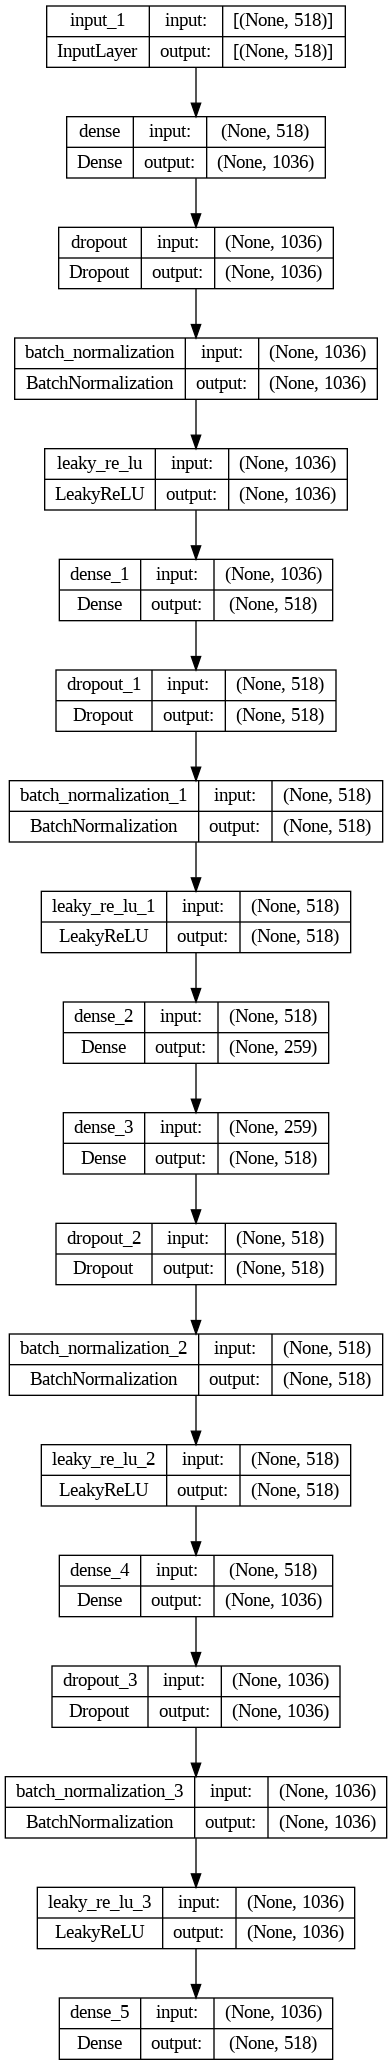

In [ ]:
%%time
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt

keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

model, input, output, bottleneck = create_ae(optimizer='adam', dropout=.1,
                  lyrs=[X_train_m.shape[1]*2, X_train_m.shape[1]],
                  bn=True, l2=0, act='leaky',
                  train_data=X_train_m, ae=True, botnck=0.5)

plot_model(model, 'autoencoder_compress.png', show_shapes=True)

## Train the autoencoder

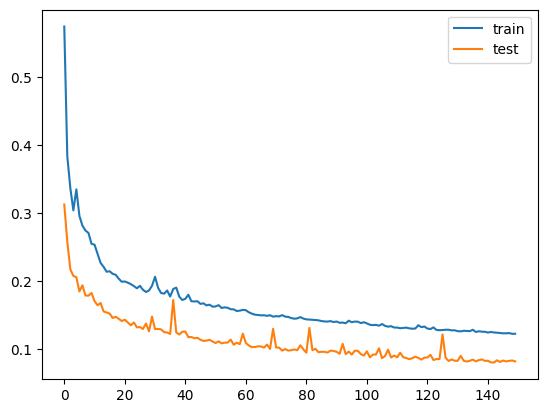

CPU times: user 2min 5s, sys: 10.9 s, total: 2min 16s
Wall time: 1min 37s


In [ ]:
%%time
history = model.fit(X_train_m, X_train_m, epochs=150, batch_size=512,  #60, 512
                    verbose=0, validation_data=(X_test,X_test))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


## Create the encoder

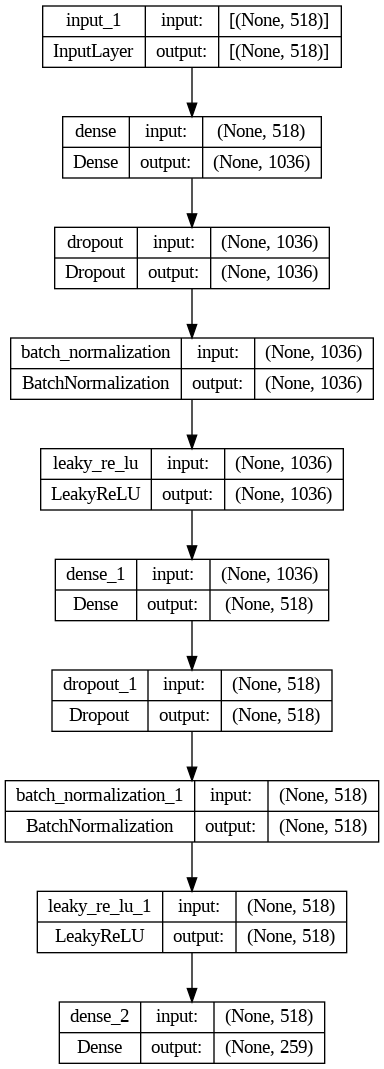

In [ ]:
encoder = Model(inputs=input, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
#encoder.save('encoder.h5')

## Create encoded training and test data

In [ ]:
X_train_encode = encoder.predict( X_train_m )
X_val_encode = encoder.predict( X_val )
X_test_encode = encoder.predict( X_test )

155/155 [==============================] - 0s 1ms/step


## Use Randomized Grid search to find best model using encoded data.

Fit using the train and validation merged data.

In [ ]:
def print_results(_results, _X_train, _y_train, _X_test, _y_test, _X_val, _y_val):
  print("Best: %f using %s" % (_results.best_score_, _results.best_params_))
  print("Reclassification Score: %f" % (_results.best_estimator_.score(_X_train, _y_train)) )
  print("Validation Score: %f" % (_results.best_estimator_.score(_X_val, _y_val)) )
  print("Test Score: %f" % (_results.best_estimator_.score(_X_test, _y_test)) )
  means =  _results.cv_results_['mean_test_score']
  stds =   _results.cv_results_['std_test_score']
  params = _results.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV


In [ ]:
batch_size = [128, 256, 512, 1250]
epochs = [100, 110, 200, 400]
optimizer = ['adam', 'RMSprop']
dropout = [0.2, 0.5, 0.7]
lyrs = [[3000, 500],[2500, 500]]
bn = [True, False]
l2 = [0, 0.001]

param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  model__optimizer=optimizer,
                  model__dropout=dropout,
                  model__lyrs=lyrs,
                  model__bn=bn,
                  model__l2=l2)

In [ ]:
%%time

keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

verbose_level = 5

TRAIN_DATA = X_train_m
TRAIN_Y = y_train_m

TEST_DATA = X_test
TEST_Y = y_test

def create_model(optimizer, dropout, lyrs, bn, l2):

  _model = keras.Sequential()
  _model.add( tf.keras.Input(shape=(TRAIN_DATA.shape[1],)) )

  for lyr in lyrs:
    if l2 is not None:
      _model.add( layers.Dense(lyr, activation="relu",
                               kernel_regularizer=regularizers.l2(l2)) )
    else:
      _model.add( layers.Dense(lyr, activation="relu") )
    _model.add( layers.Dropout(dropout) )
    if bn:
      _model.add( BatchNormalization() )

  _model.add( layers.Dense(16, activation="softmax") )

  _model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return _model

model = KerasClassifier(model=create_model, verbose= verbose_level)

grid = RandomizedSearchCV(estimator = model,
                               param_distributions = param_grid,
                               n_iter = 10, cv = 5, verbose= verbose_level,
                               random_state=seed, n_jobs = 10)

grid_result = grid.fit(TRAIN_DATA, TRAIN_Y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

In [ ]:
print_results(grid_result, TRAIN_DATA, TRAIN_Y, TEST_DATA, TEST_Y, X_val, y_val)

Best: 0.696754 using {'model__optimizer': 'adam', 'model__lyrs': [2500, 500], 'model__l2': 0, 'model__dropout': 0.7, 'model__bn': True, 'epochs': 200, 'batch_size': 1250}
Reclassification Score: 0.990862
Validation Score: 0.990009
Test Score: 0.642900
0.688266 (0.003027) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0.001, 'model__dropout': 0.7, 'model__bn': False, 'epochs': 110, 'batch_size': 1250}
0.685242 (0.005473) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0.001, 'model__dropout': 0.5, 'model__bn': False, 'epochs': 200, 'batch_size': 256}
0.685690 (0.012332) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0, 'model__dropout': 0.2, 'model__bn': True, 'epochs': 110, 'batch_size': 1250}
0.696754 (0.008253) with: {'model__optimizer': 'adam', 'model__lyrs': [2500, 500], 'model__l2': 0, 'model__dropout': 0.7, 'model__bn': True, 'epochs': 200, 'batch_size': 1250}
0.680359 (0.007664) with: {'model__

In [ ]:
grid_result.best_estimator_.model_.save('/content/data/mel_sg/models/MLP_LARGE_v10.keras')

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/content/data/mel_sg/models/MLP_LARGE_v10.keras')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2500)              1297500   
                                                                 
 dropout_4 (Dropout)         (None, 2500)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2500)              10000     
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 500)               1250500   
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 500)               2000      
 chNormalization)                                       

## Lets fit using the encoded input data.

In [ ]:
X_train_encode.shape

(44647, 259)

In [ ]:
%%time
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

TRAIN_DATA = X_train_encode
TRAIN_Y = y_train_m

TEST_DATA = X_test_encode
TEST_Y = y_test

verbose_level=5

def create_model(optimizer, dropout, lyrs, bn, l2):

  _model = keras.Sequential()
  _model.add( tf.keras.Input(shape=(TRAIN_DATA.shape[1],)) )

  for lyr in lyrs:
    if l2 is not None:
      _model.add( layers.Dense(lyr, activation="relu",
                               kernel_regularizer=regularizers.l2(l2)) )
    else:
      _model.add( layers.Dense(lyr, activation="relu") )
    _model.add( layers.Dropout(dropout) )
    if bn:
      _model.add( BatchNormalization() )

  _model.add( layers.Dense(16, activation="softmax") )

  _model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return _model

model = KerasClassifier(model=create_model, verbose= verbose_level)

batch_size = [512, 1250, 1500]
epochs = [100, 110, 200, 400]
optimizer = ['adam', 'RMSprop']
dropout = [0.2, 0.5, 0.7]
lyrs = [[3000, 500],[2500, 500]]
bn = [True, False]
l2 = [0, 0.001]

param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  model__optimizer=optimizer,
                  model__dropout=dropout,
                  model__lyrs=lyrs,
                  model__bn=bn,
                  model__l2=l2)

grid_enc = RandomizedSearchCV(estimator = model,
                               param_distributions = param_grid,
                               n_iter = 10, cv = 5, verbose= verbose_level,
                               random_state=seed, n_jobs = 10)

grid_result_enc = grid_enc.fit(TRAIN_DATA, TRAIN_Y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/110
Epoch 2/110
Epoch 3/110
Epoch 4/110
Epoch 5/110
Epoch 6/110
Epoch 7/110
Epoch 8/110
Epoch 9/110
Epoch 10/110
Epoch 11/110
Epoch 12/110
Epoch 13/110
Epoch 14/110
Epoch 15/110
Epoch 16/110
Epoch 17/110
Epoch 18/110
Epoch 19/110
Epoch 20/110
Epoch 21/110
Epoch 22/110
Epoch 23/110
Epoch 24/110
Epoch 25/110
Epoch 26/110
Epoch 27/110
Epoch 28/110
Epoch 29/110
Epoch 30/110
Epoch 31/110
Epoch 32/110
Epoch 33/110
Epoch 34/110
Epoch 35/110
Epoch 36/110
Epoch 37/110
Epoch 38/110
Epoch 39/110
Epoch 40/110
Epoch 41/110
Epoch 42/110
Epoch 43/110
Epoch 44/110
Epoch 45/110
Epoch 46/110
Epoch 47/110
Epoch 48/110
Epoch 49/110
Epoch 50/110
Epoch 51/110
Epoch 52/110
Epoch 53/110
Epoch 54/110
Epoch 55/110
Epoch 56/110
Epoch 57/110
Epoch 58/110
Epoch 59/110
Epoch 60/110
Epoch 61/110
Epoch 62/110
Epoch 63/110
Epoch 64/110
Epoch 65/110
Epoch 66/110
Epoch 67/110
Epoch 68/110
Epoch 69/110
Epoch 70/110
Epoch 71/110
Epoch 72/110
Epoch 73/110
Epoch 74/110
Epoch 75/110
Epoch 76/110
Epoch 77/110
Epoch 78

In [ ]:
print_results(grid_result_enc, TRAIN_DATA, TRAIN_Y, TEST_DATA, TEST_Y, X_val_encode, y_val)

Best: 0.688467 using {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0.001, 'model__dropout': 0.7, 'model__bn': False, 'epochs': 110, 'batch_size': 1250}
Reclassification Score: 0.927162
Validation Score: 0.935162
Test Score: 0.634619
0.688467 (0.007019) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0.001, 'model__dropout': 0.7, 'model__bn': False, 'epochs': 110, 'batch_size': 1250}
0.674312 (0.010702) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0.001, 'model__dropout': 0.5, 'model__bn': False, 'epochs': 200, 'batch_size': 256}
0.675140 (0.012134) with: {'model__optimizer': 'adam', 'model__lyrs': [3000, 500], 'model__l2': 0, 'model__dropout': 0.2, 'model__bn': True, 'epochs': 110, 'batch_size': 1250}
0.679060 (0.011962) with: {'model__optimizer': 'adam', 'model__lyrs': [2500, 500], 'model__l2': 0, 'model__dropout': 0.7, 'model__bn': True, 'epochs': 200, 'batch_size': 1250}
0.679441 (0.009228) with: {'mo

In [ ]:
grid_result_enc.best_estimator_.model_.save('/content/data/mel_sg/models/MLP_LARGE_AC_v10.keras')

In [ ]:
import tensorflow as tf
loaded_model_enc = tf.keras.models.load_model('/content/data/mel_sg/models/MLP_LARGE_AC_v10.keras')

In [ ]:
loaded_model_enc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3000)              780000    
                                                                 
 dropout_4 (Dropout)         (None, 3000)              0         
                                                                 
 dense_7 (Dense)             (None, 500)               1500500   
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                8016      
                                                                 
Total params: 2288516 (8.73 MB)
Trainable params: 2288516 (8.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
